In [1]:
import cv2, numpy as np
import matplotlib.pyplot as plt
k_shape = (5,5)
ker_rct = cv2.getStructuringElement(cv2.MORPH_RECT      ,k_shape)
ker_ell = cv2.getStructuringElement(cv2.MORPH_ELLIPSE   ,k_shape)
ker_crs = cv2.getStructuringElement(cv2.MORPH_CROSS     ,k_shape)
print(ker_rct,ker_ell,ker_crs, sep='\n\n')

[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]

[[0 0 1 0 0]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [0 0 1 0 0]]

[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]


In [2]:
ker_ellipse = lambda ks: cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ks,ks))

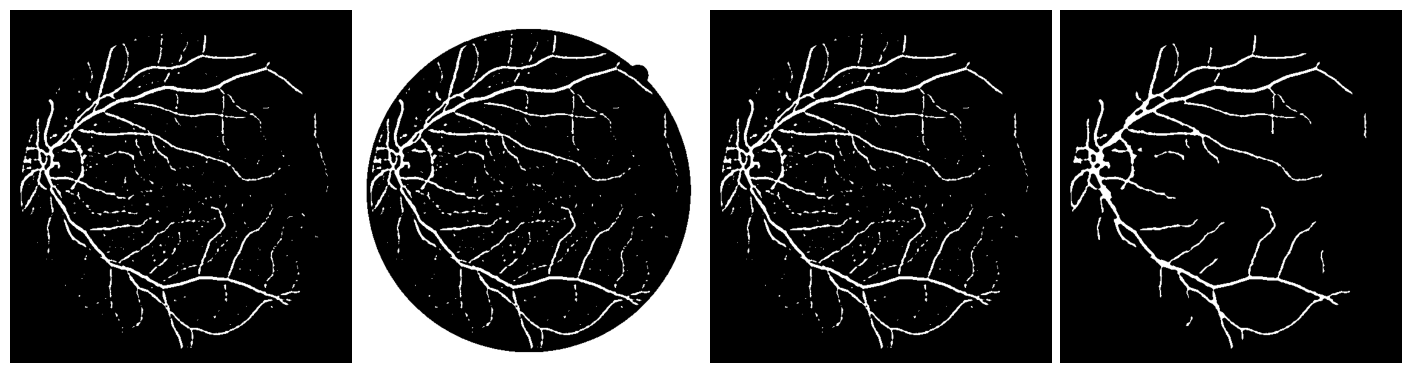

In [4]:
import numpy as np
import cv2

fig, ax = plt.subplots(1, 4, figsize=(14, 8), layout="constrained")
lnk = r'../media/vessel.png'
img = cv2.imread(lnk, 0)

# PRE_PROCESSING
k_size = 7
img_blur = cv2.GaussianBlur(img, (k_size,k_size), 0)

thresh = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 3)
imgs = [thresh]
cv2.floodFill(thresh, None, (0,0), 255)
imgs.append(thresh.copy())
cv2.floodFill(thresh, None, (0,0), 0)

# STUFF STARTS HERE
k_size2 = 3

ker_ell = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k_size2,k_size2))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, ker_ell)

imgs.append(thresh.copy())

contours, _ = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

min_contour_area = 20
contours_filtered = [c for c in contours if cv2.contourArea(c) > min_contour_area]

blank = np.zeros_like(img, dtype=np.uint8)
cv2.drawContours(blank, contours_filtered, -1, 255, -1)

k_size3 = 7
ker_ell = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k_size3,k_size3))
blank = cv2.morphologyEx(blank, cv2.MORPH_CLOSE, ker_ell)

imgs.append(blank)
for i,im in enumerate(imgs):
    ax[i].imshow(im, 'gray')
    ax[i].axis('off')
plt.show()

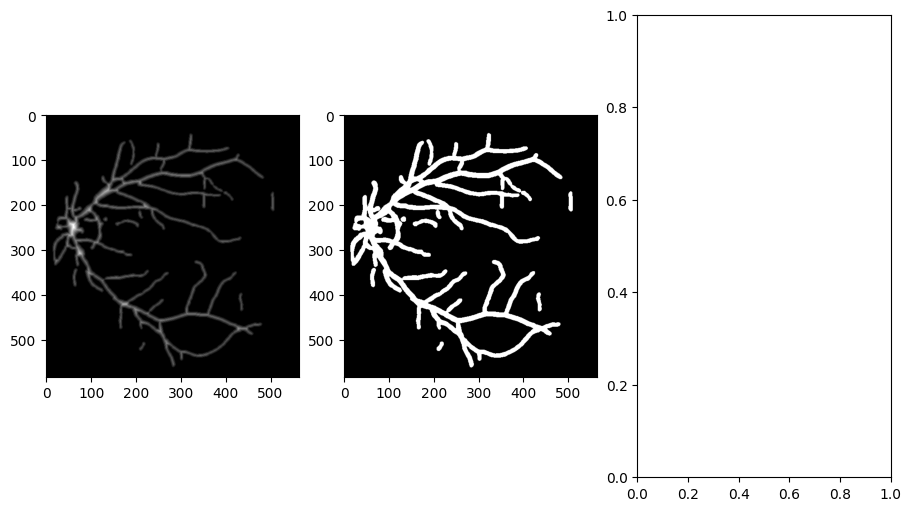

In [5]:
from skimage.morphology import skeletonize
from scipy.ndimage import distance_transform_cdt
fig, ax = plt.subplots(1, 3, figsize=(9, 5), layout="constrained")

k_size = 11
blank2 = cv2.GaussianBlur(blank, (k_size,k_size), 0)

thld0 = np.uint8(blank2 > 10) * 255
dtr = distance_transform_cdt(thld0, metric="chessboard")

# skel = np.uint8(skeletonize(blank))
ax[0].imshow(dtr, 'gray')

thld = np.uint8(dtr > 0.1) * 255
# k_size2 = 11
# ker_ell = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k_size2,k_size2))
# open1 = cv2.morphologyEx(skel, cv2.MORPH_CLOSE, ker_ell)
ax[1].imshow(thld, 'gray')

# skel2 = np.uint8(skeletonize(open1))

# ax[2].imshow(skel2, 'gray')


In [7]:
#00628627
#KGV36UW30/05
# img1 = cv2.imread(r'e:\relocated\Downloads\1.png',flags=cv2.IMREAD_GRAYSCALE)
# img2 = cv2.imread(r'e:\relocated\Downloads\2.png',flags=cv2.IMREAD_GRAYSCALE)

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (2349081909.py, line 1)